# Efficient Frontier Test

The goal of this model is to compare the efficient frontier of using the standard covariance matrix and the Gerber covariance matrix

# Packages

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Accessing Gerber Object

In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))
from Gerber import Gerber

# Problem Setup

Given the relevant technical problems that already occur with different aspects of the efficient frontier we will be optimizing a portfolio of 12 assets. 

In [3]:
df = pd.read_parquet(path = "df.parquet", engine = "pyarrow")

random.seed(4444)
cols = df.columns.to_list()
random.shuffle(cols)
rand_cols = cols[0:12]

df_tmp = df[rand_cols]

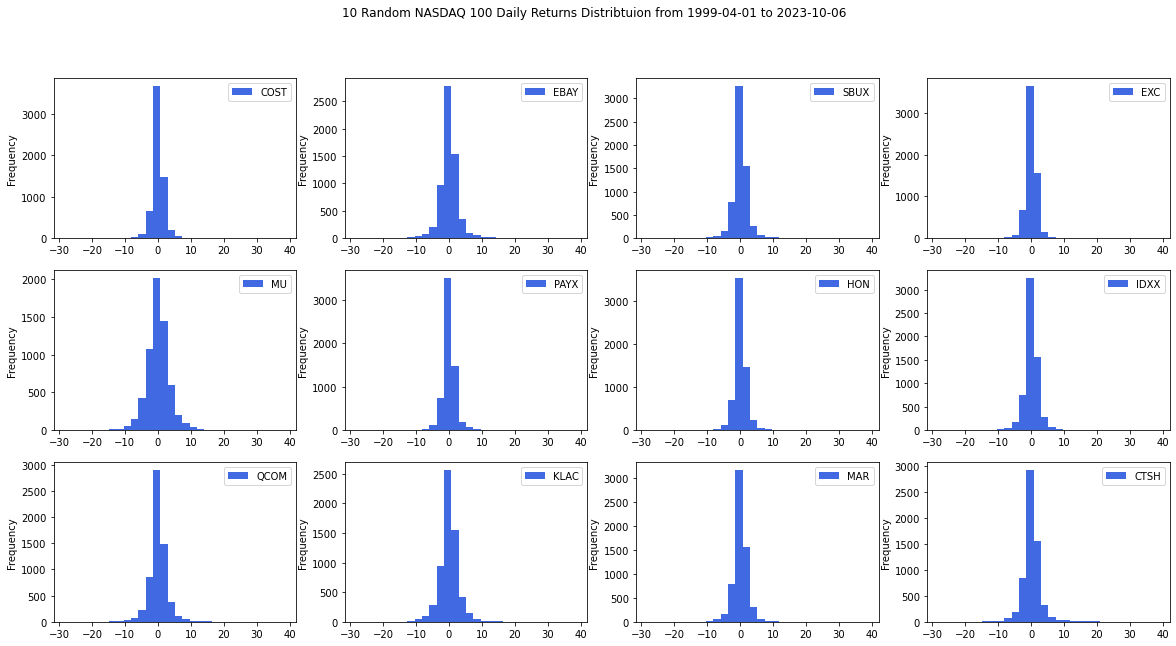

In [7]:
((df_tmp * 100).plot(
    kind = "hist",
    subplots = True,
    layout = (3,4),
    figsize = (20,10),
    bins = 30,
    sharex = False,
    color = "royalblue",
    title = "10 Random NASDAQ 100 Daily Returns Distribtuion from {} to {}".format(
        df_tmp.index.min().date(),
        df_tmp.index.max().date())))

plt.show()

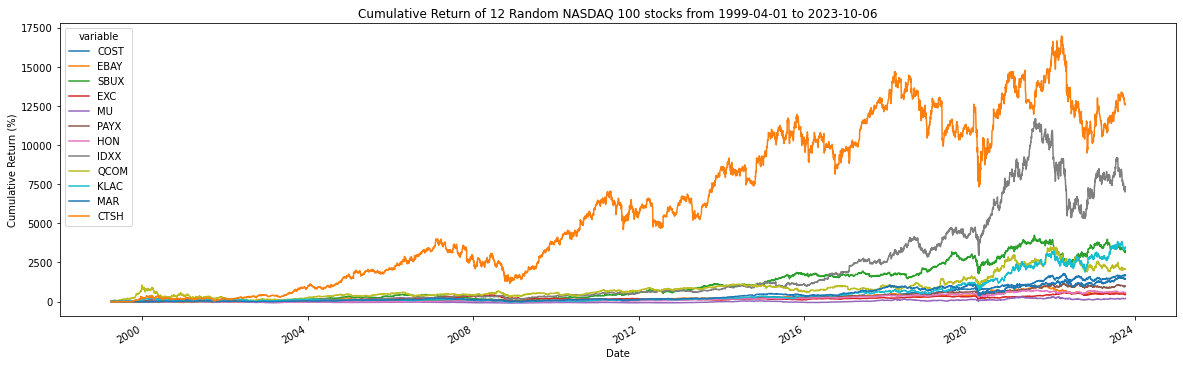

In [5]:
((np.cumprod(1 + df_tmp) - 1) * 100).plot(
    figsize = (20,6),
    ylabel = "Cumulative Return (%)",
    title = "Cumulative Return of 12 Random NASDAQ 100 stocks from {} to {}".format(
        df_tmp.index.min().date(),
        df_tmp.index.max().date()))

plt.show()

# Getting Parameters

In [6]:
mu = df_tmp.mean()
cov = df_tmp.cov()
gerber_cov = Gerber(df_tmp).cov()

# Method 1: Monte Carlo Simulation

In [47]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):

    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std

    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(returns, risk, num_portfolios, rf):

    results_matrix = np.zeros((len(returns)+3, num_portfolios))

    for i in range(num_portfolios):

        if i % 10000 == 0:

            print("simulated", i, "portfolios") 

        weights = np.random.random(len(returns))
        weights /= np.sum(weights)

        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, returns, risk, rf)

        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio

        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]       

    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in mu.index.to_list()])

    return results_df  

In [48]:
ef_cov = simulate_random_portfolios(mu, cov, num_portfolios = 100_000, rf = 0)
ef_gerber = simulate_random_portfolios(mu, gerber_cov, num_portfolios = 100_000, rf = 0)

simulated 0 portfolios
simulated 10000 portfolios
simulated 20000 portfolios
simulated 30000 portfolios
simulated 40000 portfolios
simulated 50000 portfolios
simulated 60000 portfolios
simulated 70000 portfolios
simulated 80000 portfolios
simulated 90000 portfolios
simulated 0 portfolios
simulated 10000 portfolios
simulated 20000 portfolios
simulated 30000 portfolios
simulated 40000 portfolios
simulated 50000 portfolios
simulated 60000 portfolios
simulated 70000 portfolios
simulated 80000 portfolios
simulated 90000 portfolios


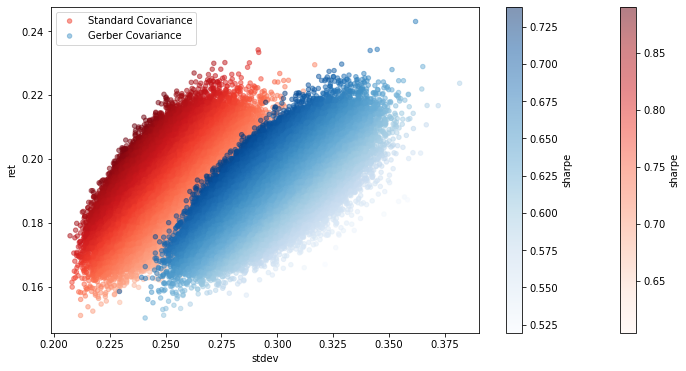

In [55]:
fig, axes = plt.subplots(figsize = (12,6))

(ef_cov.plot(
    kind = "scatter",
    x = "stdev", y = "ret", c = "sharpe",
    cmap = "Reds",
    alpha = 0.5,
    ax = axes,
    label = "Standard Covariance"))

(ef_gerber.plot(
    kind = "scatter",
    x = "stdev", y = "ret", c = "sharpe",
    cmap = "Blues",
    alpha = 0.5,
    ax = axes,
    label = "Gerber Covariance"))

axes.legend()
plt.show()

Let's Extract the top 100 sharpe ratios and analyze them

In [94]:
cov_sharpe = (ef_cov[
    ["sharpe"]].
    sort_values("sharpe", ascending = False).
    head(1_000).
    sharpe.
    to_list())

gerber_sharpe = (ef_gerber[
    ["sharpe"]].
    sort_values("sharpe", ascending = False).
    head(1_000).
    sharpe.
    to_list())

df_sharpe = (pd.DataFrame({
    "Covariance Matrix": cov_sharpe,
    "Gerber Matrix": gerber_sharpe}))

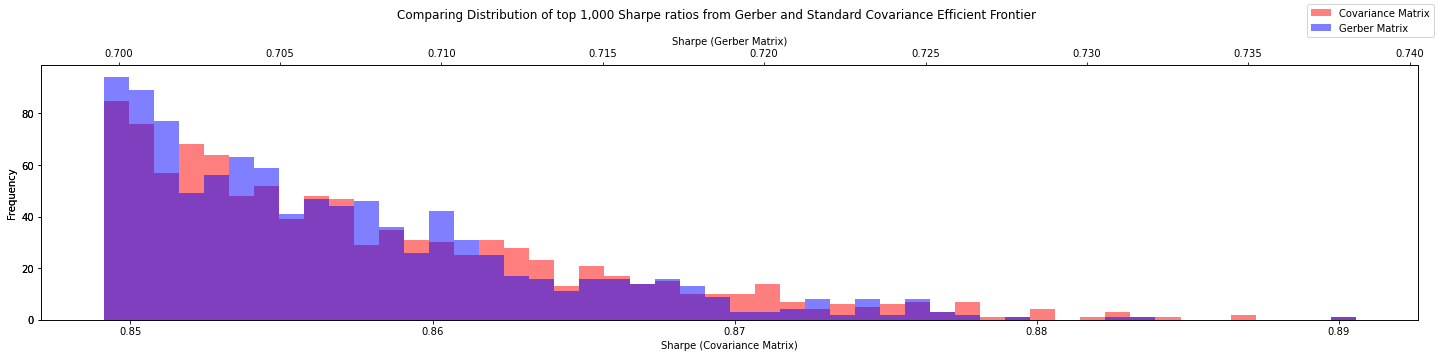

In [117]:
fig, axes = plt.subplots(figsize = (20,5))

(df_sharpe["Covariance Matrix"].plot(
    kind = "hist",
    ax = axes,
    color = "red",
    alpha = 0.5,
    bins = 50,
    label = "Covariance Matrix"))

twiny = axes.twiny()

(df_sharpe["Gerber Matrix"].plot(
    kind = "hist",
    ax = twiny,
    alpha = 0.5,
    color = "blue",
    bins = 50,
    label = "Gerber Matrix"))

axes.set_xlabel("Sharpe (Covariance Matrix)")
twiny.set_xlabel("Sharpe (Gerber Matrix)")

fig.legend()
fig.suptitle("Comparing Distribution of top 1,000 Sharpe ratios from Gerber and Standard Covariance Efficient Frontier")

plt.tight_layout()

Comparing allocations between top 1,000 portfolios of each method

In [148]:
cov_weights = (ef_cov.sort_values(
    "sharpe", ascending = False).
    head(1_000).
    drop(columns = ["ret", "stdev", "sharpe"]).
    reset_index(drop = True).
    reset_index().
    melt(id_vars = "index", value_name = "cov"))

gerber_weights = (ef_gerber.sort_values(
    "sharpe", ascending = False).
    head(1_000).
    drop(columns = ["ret", "stdev", "sharpe"]).
    reset_index(drop = True).
    reset_index().
    melt(id_vars = "index", value_name = "gerber"))

df_compare = (cov_weights.merge(right = gerber_weights, how = "inner", on = ["index", "variable"]))

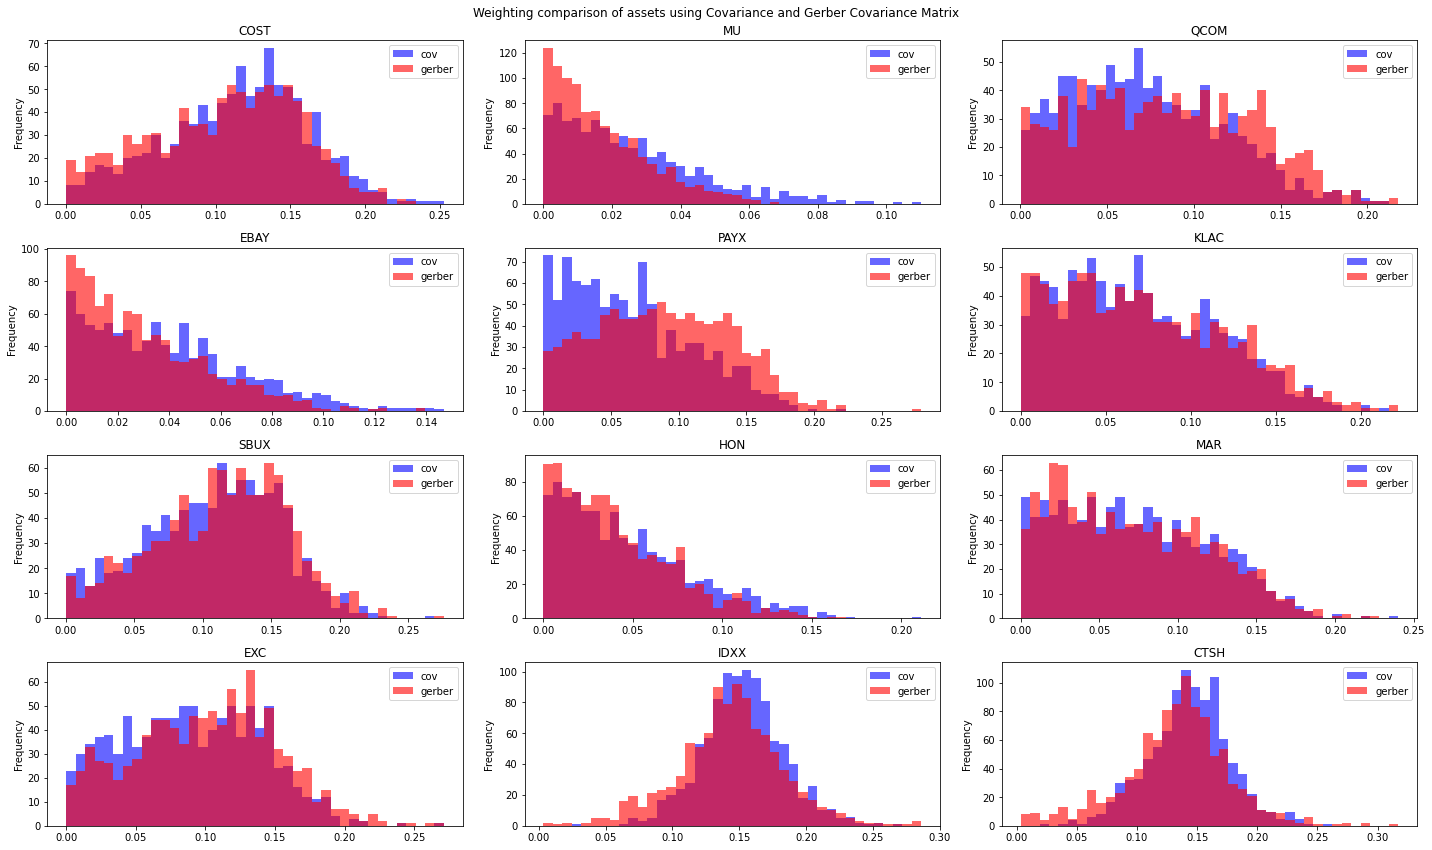

In [169]:
tickers = df_compare.variable.drop_duplicates().to_list()

fig, axes = plt.subplots(ncols = 3, nrows = 4, figsize = (20,12))

i, j = 0,0
for ticker in tickers:
    
    df_tmp = df_compare.query("variable == @ticker")
        
    (df_tmp[
        ["cov", "gerber"]].
        plot(
            kind = "hist", bins = 40, alpha = 0.6,
            color = ["blue", "red"],
            title = df_tmp.variable.iloc[0],
            ax = axes[i,j]))
    
    if i == 3:
        i = 0
        j += 1
        
    else: 
        i += 1
        
fig.suptitle("Weighting comparison of assets using Covariance and Gerber Covariance Matrix")
plt.tight_layout()